In [3]:
!pip install meteocalc

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')
#!cp /content/drive/MyDrive/ashrae.zip ashrae.zip
#!unzip -q ashrae.zip

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.figure_factory as ff

from IPython.core.pylabtools import figsize
from plotly.offline import init_notebook_mode,iplot,plot
%matplotlib inline
init_notebook_mode(connected=True)
plt.style.use("ggplot")

from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.preprocessing import  LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

# importer les fichiers .py sur le notebook
%run utils.py
%run feature_enginering.py

In [6]:
building = pd.read_csv('/content/building_metadata.csv')
weather = pd.read_csv('/content/weather_train.csv')
train = pd.read_csv('/content/train.csv')

train.loc[(train.meter == 0),'meter_reading'] = train['meter_reading'] * 0.2931 # convertir du kwh vers kbtu

In [7]:
building = reduce_mem_usage(building)
weather  = reduce_mem_usage(weather)
train = reduce_mem_usage(train)

In [8]:
building = prepare_building_data(building)
weather = prepare_weather_data(weather)
train  = time_features(train)

In [9]:
def join_data(data , weather_data , building_data):

    data = data.merge(building_data, on = 'building_id' , how='left')
    data = data.merge(weather_data , on = ['site_id','timestamp'], how= 'left')
    data = shuffle(data, random_state=0)

    return data

train = join_data(train , weather , building)

train['log_meter_reading'] = np.log(train['meter_reading'] + 1)
train['month_group'] = train['month_group'] - 1

train = train.drop(['meter_reading'] , axis= 1)

del weather, building
gc.collect()

26

In [10]:
cols_to_drop = ['year_built' , 'floor_count' , 'timestamp']

cols_to_scale = ['square_feet' , 'air_temperature' , 'dew_temperature' ,
                 'wind_speed', 'cloud_coverage', 'sea_level_pressure', 
                 'wind_direction', 'relative_humidity', 'feels_like']

cols_to_encode = ['primary_use' , 'city' , 'country']

cols_to_fill_median = ['air_temperature', 'cloud_coverage', 'dew_temperature', 
                       'precip_depth_1_hr', 'sea_level_pressure','wind_direction', 
                       'wind_speed', 'relative_humidity' ,'feels_like']

cols_to_fill_categ = ['city' , 'country' , 'is_holiday']


Filler = Data_Filler(cols_to_fill_median,
                     cols_to_fill_categ)

Filler.fit(train)
train = Filler.transform(train)

ScalerEncoder = Data_Scaler_Encoder(cols_to_scale ,
                                    cols_to_drop , 
                                    cols_to_encode)
ScalerEncoder.fit(train)
train = ScalerEncoder.transform(train)

In [11]:
categorical_vars = ['building_id' , 'meter', 'hour', 'dayofweek' , 
                    'month_group', 'site_id' , 
                    'primary_use', 'city', 'country', 'is_holiday']

for col in categorical_vars:
    train[col] = train[col].astype('category')

train  = reduce_mem_usage(train)
train_columns = train.columns

In [12]:
y = train['log_meter_reading'].values

train = train.drop( ['log_meter_reading'] , axis = 1).values

train, valid, y_train, y_valid = train_test_split(train, y, test_size = 0.30, random_state=42)

del y
gc.collect()

50

In [19]:
GBR =  GradientBoostingRegressor(n_estimators = 25 ,
                          max_depth = 25, 
                          min_samples_split = 12  ,
                          min_samples_leaf = 6 ,
                          max_leaf_nodes = None ,
                          min_impurity_split = 0 , 
                          verbose = 1)
GBR.fit(train , y_train )
y_pred = GBR.predict(valid)
print(mean_squared_error(y_valid, y_pred, squared = False))

      Iter       Train Loss   Remaining Time 
         1           3.8486          215.12m
         2           3.1666          196.55m
         3           2.6117          183.84m
         4           2.1596          174.37m
         5           1.7915          165.76m
         6           1.4912          157.05m
         7           1.2452          146.80m
         8           1.0443          134.29m
         9           0.8802          122.49m
        10           0.7451          111.83m
        20           0.2002           33.27m
0.586263892096948


In [14]:
del y_pred
gc.collect()

254

In [15]:
train = np.concatenate((train , valid) , axis = 0)
y_train = np.concatenate((y_train , y_valid) , axis = 0)

In [16]:
GBR = GradientBoostingRegressor(n_estimators = 25 ,
                          max_depth = 25, 
                          min_samples_split = 12  ,
                          min_samples_leaf = 6 ,
                          max_leaf_nodes = None ,
                          min_impurity_split = 0 , 
                          verbose = 1)

GBR.fit(train , y_train)

      Iter       Train Loss   Remaining Time 
         1           3.8462          241.91m
         2           3.1629          224.31m
         3           2.6072          211.31m
         4           2.1546          199.73m
         5           1.7860          188.59m
         6           1.4853          178.38m
         7           1.2400          167.85m
         8           1.0396          154.92m
         9           0.8756          143.15m
        10           0.7410          132.22m
        20           0.2008           43.58m


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=25,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=0,
                          min_samples_leaf=6, min_samples_split=12,
                          min_weight_fraction_leaf=0.0, n_estimators=25,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=1, warm_start=False)

In [17]:
del train, y_train
gc.collect()

782

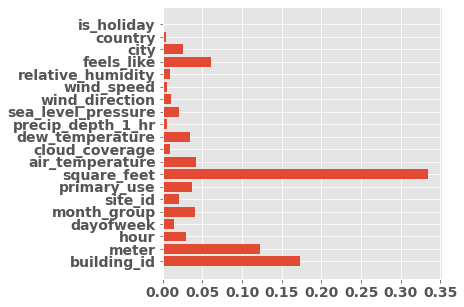

In [30]:
importance = GBR.feature_importances_
plt.figure(figsize = (5 , 5))
plt.barh(train_columns[:-1], importance)
plt.xticks(fontsize = 14 , fontweight = "bold")
plt.yticks(fontsize = 14 , fontweight = "bold")
plt.show()

In [19]:
test = pd.read_csv('/content/test.csv')
weather_test = pd.read_csv('/content/weather_test.csv')
building = pd.read_csv('/content/building_metadata.csv')


weather_test  = reduce_mem_usage(weather_test)
building = reduce_mem_usage(building)
test = reduce_mem_usage(test)


weather_test = prepare_weather_data(weather_test)
building = prepare_building_data(building)
test = time_features(test)

In [22]:
step_size = 100000
nrows = test.shape[0]
num_steps = nrows//step_size
print('nombre d\'iterations' , num_steps)

row_id = np.array([])
meter_values = np.array([])
y_pred = np.array([])

for j in range(num_steps+1):
    start_idx = j*step_size
    end_idx = (j+1)*step_size
    if j == num_steps : 
        start_idx = j*step_size
        end_idx = nrows
      
    test_tmp = test.iloc[start_idx:end_idx]
    
    test_tmp = join_data(test_tmp , weather_test , building)
    #test_tmp = test_tmp[['row_id'] + most_important_variables[:-1]]
    
    test_tmp = Filler.transform(test_tmp)
    test_tmp = ScalerEncoder.transform(test_tmp)
    test_tmp['month_group'] = test_tmp['month_group'] - 1
    
    for col in categorical_vars:
        test_tmp[col] = test_tmp[col].astype('category')

    row_id_tmp = test_tmp['row_id'].values
    row_id = np.concatenate((row_id,row_id_tmp))

    test_tmp = test_tmp.drop(['row_id'] , axis= 1)

    meter_values_tmp = test_tmp['meter'].values
    meter_values = np.concatenate((meter_values,meter_values_tmp))

    predictions = GBR.predict(test_tmp)
    predictions = predictions.reshape(predictions.shape[0])

    y_pred = np.concatenate((y_pred,predictions))
    if j%50==0:
        print('iteration' , j)

nombre d'iterations 416
iteration 0
iteration 50
iteration 100
iteration 150
iteration 200
iteration 250
iteration 300
iteration 350
iteration 400


In [23]:
pred_final = {'row_id': row_id, 'meter' : meter_values , 'meter_reading': y_pred}
pred_final = pd.DataFrame(data = pred_final)

KWH_TO_KBTU = 0.2931 
pred_final['meter_reading'] = np.exp(pred_final['meter_reading']) - 1
pred_final.loc[(pred_final.meter == 0),'meter_reading'] = pred_final['meter_reading'] / KWH_TO_KBTU # convertir du kwh vers kbtu

pred_final = pred_final.sort_values(by=['row_id'])
pred_final = pred_final.drop(['meter'] , axis = 1)
pred_final.loc[pred_final.meter_reading < 0, 'meter_reading'] = 0

In [24]:
pred_final.row_id = pred_final.row_id.astype('int32')
pred_final

,row_id,meter_reading
52860,0,0.974518
33031,1,1.764023
83905,2,0.975335
15517,3,0.974119
46516,4,1.040821
...,...,...
41640965,41697595,6.134934
41659597,41697596,6.078382
41675115,41697597,8.859460
41629031,41697598,159.323286


In [25]:
compression_opts = dict(method='zip',archive_name='GBR_out.csv')  

pred_final.to_csv('GBR_out.zip', index=False,compression=compression_opts)

In [26]:
!cp GBR_out.zip /content/drive/MyDrive/GBR_out.zip